# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

from pyspark.sql import SparkSession

from pyspark.sql import Window

from pyspark.sql.functions import col, udf, desc, asc, avg, count, countDistinct, max, min, approx_count_distinct
from pyspark.sql.functions import sum as Fsum

from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType

import numpy as np
import pandas as pd

from scipy.stats import norm

from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, Normalizer, MinMaxScaler

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier

from pyspark.ml.clustering import KMeans

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# create a Spark session

spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# read dataset from json file
df = spark.read.json("mini_sparkify_event_data.json")
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
# check schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# check data
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
# number of rows
df.count()

286500

In [7]:
# number of rows with blank userId or sessionId
df.filter((df.userId == "") | (df.sessionId == "")).count()

8346

In [8]:
# drop rows with na or blank userId or sessionId
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"]) \
    .filter(~((df.userId == "") & (df.sessionId == "")))

In [9]:
# check result
df_valid.filter((df.userId == "") | (df.sessionId == "")).count()

0

In [10]:
# number of valid rows
df_valid.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Detecting Churn

In [11]:
# udf to mark churn events
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# mark churn events in column 'event'
df_churn = df_valid.withColumn("event", flag_churn_event("page"))

In [12]:
# check result
df_churn.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', event=0)

In [13]:
# mark users with a churn event as 'churned'

window_churn = Window.partitionBy("userId") \
    .orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

df_churned = df_churn.withColumn("churned", Fsum("event").over(window_churn))

#### Exploring Data

In [14]:
# number of churned / not churned users
df_users_spark = df_churned.select('userId', 'churned') \
                    .distinct() \
                    .groupby('churned') \
                    .count() \
                    .sort('churned')

df_users_spark.show()

+-------+-----+
|churned|count|
+-------+-----+
|      0|  173|
|      1|   52|
+-------+-----+



In [15]:
# set up window for calculations per user
windowval = Window.partitionBy("userId")

# number of sessions per user
df_churned = df_churned.withColumn("no_sessions", approx_count_distinct('sessionId').over(windowval))

# overall time span (in days) per user
time_scale = 24 * 60 * 60 * 1000
df_churned = df_churned.withColumn("time_span", (max('ts').over(windowval) - min('ts').over(windowval))/time_scale)

# check result
df_churned.select('userId', 'churned', 'no_sessions', 'time_span') \
                    .distinct() \
                    .groupby('churned') \
                    .avg('no_sessions', 'time_span') \
                    .sort('churned').show()

+-------+------------------+-----------------+
|churned|  avg(no_sessions)|   avg(time_span)|
+-------+------------------+-----------------+
|      0|15.190751445086706|46.99087334082635|
|      1| 10.26923076923077|23.51464788105413|
+-------+------------------+-----------------+



In [16]:
# plot result on a user-basis
df_ses_time_spark = df_churned.select('userId', 'churned', 'no_sessions', 'time_span') \
                    .distinct() \
                    .groupby('churned', 'userId') \
                    .avg('no_sessions', 'time_span') \
                    .sort('userId')

# convert to pandas data frame
df_ses_time = df_ses_time_spark.toPandas()

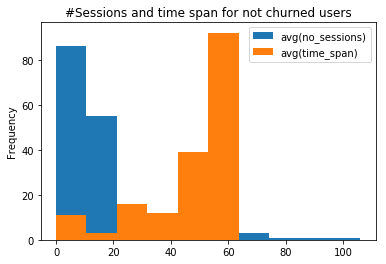

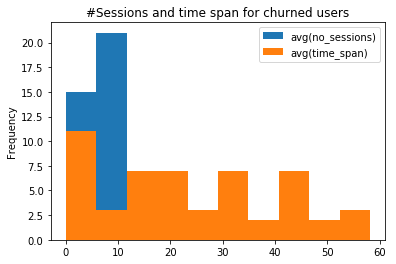

In [17]:
# plot results
df_ses_time.loc[df_ses_time['churned']==0, ['avg(no_sessions)', 'avg(time_span)']].plot(kind='hist', title='#Sessions and time span for not churned users')
df_ses_time.loc[df_ses_time['churned']==1, ['avg(no_sessions)', 'avg(time_span)']].plot(kind='hist', title='#Sessions and time span for churned users')


In [18]:
# number of page actions by churned / not churned users
df_actions_spark = df_churned.select('userId','churned', 'page', 'ts') \
                    .distinct() \
                    .groupby('churned') \
                    .count() \
                    .sort('churned')

# convert to pandas data frame
df_actions = df_actions_spark.toPandas()
df_actions

,churned,count
0,0,233274
1,1,44860


In [19]:
# number of page actions by churned / not churned users per page
df_churned.select('userId','churned', 'page', 'ts') \
    .distinct() \
    .groupby('page', 'churned') \
    .count() \
    .sort('page', 'churned').show(50)

+--------------------+-------+------+
|                page|churned| count|
+--------------------+-------+------+
|               About|      0|   438|
|               About|      1|    56|
|          Add Friend|      0|  3641|
|          Add Friend|      1|   636|
|     Add to Playlist|      0|  5488|
|     Add to Playlist|      1|  1038|
|              Cancel|      1|    52|
|Cancellation Conf...|      1|    52|
|           Downgrade|      0|  1712|
|           Downgrade|      1|   337|
|               Error|      0|   220|
|               Error|      1|    32|
|                Help|      0|  1214|
|                Help|      1|   239|
|                Home|      0|  8404|
|                Home|      1|  1671|
|              Logout|      0|  2673|
|              Logout|      1|   553|
|            NextSong|      0|191714|
|            NextSong|      1| 36394|
|         Roll Advert|      0|  2966|
|         Roll Advert|      1|   964|
|       Save Settings|      0|   252|
|       Save

In [20]:
# all pages/actions as list of strings
all_pages = df.select("page").distinct().collect()
# discard pages that are already 'too late'
pages = [p[0] for p in all_pages if p[0] not in ['Cancel', 'Cancellation Confirmation']]

# mark page event per page, re-using 'event' column
df_churned_pages = df_churned
for page in pages:
    flag_event = udf(lambda x: 1 if x == page else 0, IntegerType())
    df_churned_pages = df_churned_pages.withColumn(page, flag_event("page"))


In [21]:
# check results
df_churned_pages.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- event: integer (nullable = true)
 |-- churned: long (nullable = true)
 |-- no_sessions: long (nullable = false)
 |-- time_span: double (nullable = true)
 |-- Submit Downgrade: integer (nullable = true)
 |-- Thumbs Down: integer (nullable = true)
 |-- Home: integer (nullable = true)
 |-- Downgrade: in

In [22]:
df_churned_pages.show(n=1, truncate=False, vertical=True)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------
 artist              | null                                                                                                                                        
 auth                | Logged In                                                                                                                                   
 firstName           | Darianna                                                                                                                                    
 gender              | F                                                                                                                                           
 itemInSession       | 34                                                                                                                                          
 lastName       

In [23]:
# fraction of page actions by churned / not churned users per page
avg_pages = ['userId','churned', 'page', 'ts'] + pages
df_sig_spark = df_churned_pages.select(avg_pages) \
                .distinct() \
                .groupby('churned') \
                .avg(*pages) \
                .sort('churned')


In [24]:
# check result
df_sig_spark.show(50, truncate=False, vertical=True)

-RECORD 0-----------------------------------------
 churned                  | 0                     
 avg(Submit Downgrade)    | 2.3148743537642429E-4 
 avg(Thumbs Down)         | 0.008787948935586478  
 avg(Home)                | 0.03602630383154574   
 avg(Downgrade)           | 0.007339009062304415  
 avg(Roll Advert)         | 0.012714661728268045  
 avg(Logout)              | 0.011458628051133003  
 avg(Save Settings)       | 0.0010802746984233133 
 avg(About)               | 0.0018776203091643304 
 avg(Submit Registration) | 0.0                   
 avg(Settings)            | 0.005328497818016581  
 avg(Login)               | 0.0                   
 avg(Register)            | 0.0                   
 avg(Add to Playlist)     | 0.023525982321218823  
 avg(Add Friend)          | 0.015608254670473349  
 avg(NextSong)            | 0.8218404108473297    
 avg(Thumbs Up)           | 0.04583451220453201   
 avg(Help)                | 0.005204180491610724  
 avg(Upgrade)             | 0.0

In [25]:
# convert to pandas data frame
df_sig = df_sig_spark.toPandas()
df_sig.drop(['churned'], axis=1, inplace=True)
df_sig.columns = [co[4:-1] for co in df_sig.columns]
df_sig = df_sig.T
df_sig.rename(columns={0: 'no_churn', 1: 'churn'}, inplace=True)
df_sig['diff'] = df_sig['no_churn'] - df_sig['churn']
df_sig.sort_values(by='diff', ascending=False, inplace=True)
df_sig

,no_churn,churn,diff
NextSong,0.821840,0.811280,0.010561
Thumbs Up,0.045835,0.041440,0.004394
Add Friend,0.015608,0.014177,0.001431
About,0.001878,0.001248,0.000629
Add to Playlist,0.023526,0.023139,0.000387
Error,0.000943,0.000713,0.000230
Submit Downgrade,0.000231,0.000201,0.000031
Register,0.000000,0.000000,0.000000
Login,0.000000,0.000000,0.000000
Submit Registration,0.000000,0.000000,0.000000


In [26]:
# calculate significant differences in page frequencies
n_0 = df_actions['count'][0]
n_1 = df_actions['count'][1]

# significance level
alpha = 0.05
delta_p = norm.ppf(1-alpha/2) * \
            np.sqrt( df_sig['no_churn']*(1-df_sig['no_churn'])/n_0 + df_sig['churn']*(1-df_sig['churn'])/n_1  )

# calculate significance
df_sig['p+'] = df_sig['diff'] + delta_p 
df_sig['p-'] = df_sig['diff'] - delta_p
df_sig['significance'] = ~((df_sig['p-'] <= 0) & (df_sig['p+'] >= 0))

df_sig

,no_churn,churn,diff,p+,p-,significance
NextSong,0.821840,0.811280,0.010561,0.014501,0.006621,True
Thumbs Up,0.045835,0.041440,0.004394,0.006425,0.002364,True
Add Friend,0.015608,0.014177,0.001431,0.002635,0.000227,True
About,0.001878,0.001248,0.000629,0.001000,0.000258,True
Add to Playlist,0.023526,0.023139,0.000387,0.001908,-0.001134,False
Error,0.000943,0.000713,0.000230,0.000506,-0.000047,False
Submit Downgrade,0.000231,0.000201,0.000031,0.000176,-0.000114,False
Register,0.000000,0.000000,0.000000,0.000000,0.000000,False
Login,0.000000,0.000000,0.000000,0.000000,0.000000,False
Submit Registration,0.000000,0.000000,0.000000,0.000000,0.000000,False


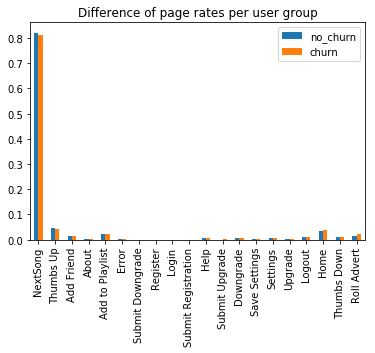

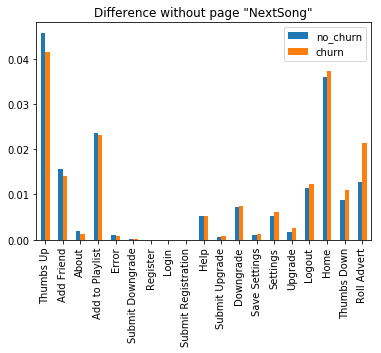

In [27]:
# plot results
df_sig[['no_churn','churn']].plot(kind='bar', title='Difference of page rates per user group')
df_sig.iloc[1:][['no_churn','churn']].plot(kind='bar', title='Difference without page "NextSong"')

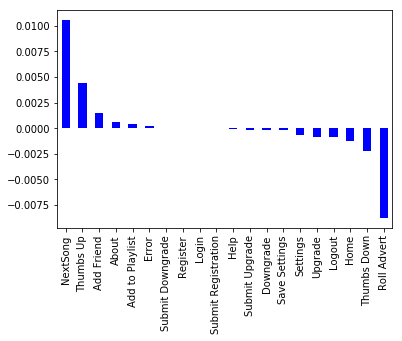

In [28]:
# plot differences
df_sig['diff'].plot(kind='bar', color=(0,0,1))

In [29]:
# extract pages with significantly different fequencies between group of churned / not churned users
pages_sig = df_sig[df_sig['significance'] == True]
pages_sig = list(pages_sig.index)
pages_sig.sort()
print(pages_sig)

['About', 'Add Friend', 'NextSong', 'Roll Advert', 'Thumbs Down', 'Thumbs Up', 'Upgrade']


### Feature Engineering

Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.

* Write a script to extract the necessary features from the smaller subset of data
* Ensure that your script is scalable, using the best practices discussed in Lesson 3
* Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [30]:
# use df_churned from above
df_model = df_churned

# user pages with significant difference between user groups
for page in pages_sig:
    flag_event = udf(lambda x: 1 if x == page else 0, IntegerType())
    df_model = df_model.withColumn(page, flag_event("page"))
    

In [31]:
# condense dataset to relevant features per user
features = ['no_sessions', 'time_span'] + pages_sig
avg_pages = ['userId','churned', 'page', 'ts'] + features

df_model_cond = df_model.select(avg_pages) \
                .distinct() \
                .groupby('userId') \
                .avg('churned', *features) \
                .sort('userId')


In [32]:
# assemble no_sessions and time_span as vector and scale min/max

assembler = VectorAssembler(inputCols=["avg(no_sessions)"], outputCol="sessionVec")
df_model_vec = assembler.transform(df_model_cond)

scaler = MinMaxScaler(inputCol="sessionVec", outputCol="sessionVecNorm")
scalerModel = scaler.fit(df_model_vec)
df_model_vec = scalerModel.transform(df_model_vec)

assembler = VectorAssembler(inputCols=["avg(time_span)"], outputCol="timeVec")
df_model_vec = assembler.transform(df_model_vec)

scaler = MinMaxScaler(inputCol="timeVec", outputCol="timeVecNorm")
scalerModel = scaler.fit(df_model_vec)
df_model_vec = scalerModel.transform(df_model_vec)

df_model_vec.show(50, vertical=True)

-RECORD 0--------------------------------
 userId           | 10                   
 avg(churned)     | 0.0                  
 avg(no_sessions) | 6.0                  
 avg(time_span)   | 42.43712962962964    
 avg(About)       | 0.002515723270440... 
 avg(Add Friend)  | 0.01509433962264151  
 avg(NextSong)    | 0.8465408805031447   
 avg(Roll Advert) | 0.001257861635220... 
 avg(Thumbs Down) | 0.005031446540880503 
 avg(Thumbs Up)   | 0.04654088050314465  
 avg(Upgrade)     | 0.0                  
 sessionVec       | [6.0]                
 sessionVecNorm   | [0.04761904761904... 
 timeVec          | [42.43712962962964]  
 timeVecNorm      | [0.6956924032735305] 
-RECORD 1--------------------------------
 userId           | 100                  
 avg(churned)     | 0.0                  
 avg(no_sessions) | 35.0                 
 avg(time_span)   | 58.96628472222223    
 avg(About)       | 0.00373366521468575  
 avg(Add Friend)  | 0.015245799626633479 
 avg(NextSong)    | 0.834474175482

In [33]:
# assemble all features as vector and normalize

assembler = VectorAssembler(inputCols=['timeVecNorm', 'sessionVecNorm']+df_model_vec.columns[4:-4], outputCol="FeatureVec")
df_model_vec = assembler.transform(df_model_vec)

scaler = Normalizer(inputCol="FeatureVec", outputCol="FeatureVecNorm")
df_model_vec = scaler.transform(df_model_vec)

#scaler = StandardScaler(inputCol="FeatureVec", outputCol="FeatureVecScaled", withMean=True, withStd=True)
#scalerModel = scaler.fit(df_model_vec)
#df_model_vec = scalerModel.transform(df_model_vec)

df_model_vec.select('FeatureVecNorm').show(1, truncate=False)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|FeatureVecNorm                                                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.6336758367456305,0.04337411146512962,0.002291462492497414,0.013748774954984486,0.7710771287253799,0.001145731246248707,0.004582924984994828,0.04239205611120216,0.0]|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
only showing top 1 row



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [34]:
# set up and cache data from data frame
data = df_model_vec.select(col("avg(churned)").alias("label"), col("FeatureVecNorm").alias("features"))
data.cache()
data.head()

Row(label=0.0, features=DenseVector([0.6337, 0.0434, 0.0023, 0.0137, 0.7711, 0.0011, 0.0046, 0.0424, 0.0]))

In [35]:
# scoring function

def score(df):
    '''
    helper function to evaluate and print score of prediction
    
    input    df: Spark Data Frame with columns 'label' and 'prediction'
    output   list [f1, accuracy, precision, recall]
    '''
    
    metrics = MulticlassMetrics(df.select(col("prediction").cast('double').alias("prediction"), 'label').rdd)
    
    f1 = metrics.fMeasure()
    accuracy = metrics.accuracy
    precision = metrics.precision(label=1)
    recall = metrics.recall(label=1)
    cmatrix = metrics.confusionMatrix().toArray()
    
    print("f1:", f1)
    print("accuracy:", accuracy)
    print("precision:", precision)
    print("recall:", recall)
    print("confusion matrix:", cmatrix)
    
    return  [f1, accuracy, precision, recall]

In [36]:
# stratified train/test split 

data_c = data.filter(data.label == 1)
data_nc = data.filter(data.label == 0)

train_c, test_c = data_c.randomSplit([0.8, 0.2], seed=42)
train_nc, test_nc = data_nc.randomSplit([0.8, 0.2], seed=42)

train = train_c.union(train_nc)
test = test_c.union(test_nc)


In [37]:
# set up pipeline, paramGrid and CrossValidation for logistic regression

lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages=[lr])

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .addGrid(lr.maxIter,[10]) \
    .build()

crossval = CrossValidator(estimator = pipeline,
                         estimatorParamMaps = paramGrid,
                         evaluator = MulticlassClassificationEvaluator(),
                         numFolds=3)

# train and tune model
cvModel = crossval.fit(train)

cvModel.avgMetrics

[0.8290546461779279, 0.7776470215082867]

In [38]:
# evaluate model on test data
lr_validation = cvModel.transform(test)
# check score
result_list = {}
result_list['Logistic Regression'] = score(lr_validation)

f1: 0.8636363636363636
accuracy: 0.8636363636363636
precision: 0.6
recall: 0.75
confusion matrix: [[ 32.   4.]
 [  2.   6.]]


In [39]:
# k-means
kmeans = KMeans().setParams(k=2, seed=42)
kmeansModel = kmeans.fit(data)


In [40]:
# evaluate model on test data
k_validation = kmeansModel.transform(test)

# check score
result_list['k-Means'] = score(k_validation)

f1: 0.7954545454545454
accuracy: 0.7954545454545454
precision: 0.45454545454545453
recall: 0.625
confusion matrix: [[ 30.   6.]
 [  3.   5.]]


In [41]:
# set up pipeline, paramGrid and CrossValidation for decision tree
dt = DecisionTreeClassifier()

dt_pipeline = Pipeline(stages=[dt])

dt_paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth,[2, 5]) \
    .build()

dt_crossval = CrossValidator(estimator = dt_pipeline,
                         estimatorParamMaps = dt_paramGrid,
                         evaluator = MulticlassClassificationEvaluator(),
                         numFolds=3)

dt_cvModel = dt_crossval.fit(train)

dt_cvModel.avgMetrics

[0.8120775315025235, 0.7860222442520163]

In [42]:
# evaluate model on test data
dt_validation = dt_cvModel.transform(test)
# check score
result_list['Decision Tree'] = score(dt_validation)

f1: 0.8636363636363636
accuracy: 0.8636363636363636
precision: 0.6666666666666666
recall: 0.5
confusion matrix: [[ 34.   2.]
 [  4.   4.]]


In [43]:
# set up pipeline, paramGrid and CrossValidation for random forest

rf = RandomForestClassifier(numTrees=10)

rf_pipeline = Pipeline(stages=[rf])

rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[2, 5, 10]) \
    .build()

rf_crossval = CrossValidator(estimator = rf_pipeline,
                         estimatorParamMaps = rf_paramGrid,
                         evaluator = MulticlassClassificationEvaluator(),
                         numFolds=3)

rf_cvModel = rf_crossval.fit(train)

rf_cvModel.avgMetrics

[0.8312255671023374, 0.7648383989343337, 0.7946748379499164]

In [44]:
# evaluate model on test data
rf_validation = rf_cvModel.transform(test)
# check score
result_list['Random Forest'] = score(rf_validation)

f1: 0.7272727272727273
accuracy: 0.7272727272727273
precision: 0.25
recall: 0.25
confusion matrix: [[ 30.   6.]
 [  6.   2.]]


In [45]:
# set up pipeline, paramGrid and CrossValidation for multilayer perceptron

# 9 features, 2 hidden layers, 2 labels
layers = [9, 5, 4, 2]
mp = MultilayerPerceptronClassifier(maxIter=100, layers=layers)

mp_pipeline = Pipeline(stages=[mp])

mp_paramGrid = ParamGridBuilder() \
    .addGrid(mp.maxIter,[2, 5, 10, 50]) \
    .build()

mp_crossval = CrossValidator(estimator = mp_pipeline,
                         estimatorParamMaps = mp_paramGrid,
                         evaluator = MulticlassClassificationEvaluator(),
                         numFolds=3)

mp_cvModel = mp_crossval.fit(train)

mp_cvModel.avgMetrics

[0.6506071117275487,
 0.6914420031890066,
 0.8087625784498869,
 0.8694629636894736]

In [46]:
# evaluate model on test data
mp_validation = mp_cvModel.transform(test)
# check score
result_list['Multilayer Perceptron'] = score(mp_validation)

f1: 0.8181818181818182
accuracy: 0.8181818181818182
precision: 0.5
recall: 0.5
confusion matrix: [[ 32.   4.]
 [  4.   4.]]


In [47]:
# final comparison of results
df_result = pd.DataFrame(result_list).T
df_result.columns=['f1', 'accuracy', 'precision', 'recall']
df_result

,f1,accuracy,precision,recall
Logistic Regression,0.863636,0.863636,0.600000,0.750
k-Means,0.795455,0.795455,0.454545,0.625
Decision Tree,0.863636,0.863636,0.666667,0.500
Random Forest,0.727273,0.727273,0.250000,0.250
Multilayer Perceptron,0.818182,0.818182,0.500000,0.500


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.